<a href="https://colab.research.google.com/github/aLehav/MLVideoDescriptionResearch/blob/main/Video_to_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions to Run:
## Video Preparation
1. Download *TVSum* Videos
2. Unzip *TVSum* Videos and Score tsv
3. Create a folder or path of folders in google drive, and change `drive_path`in this notebook to be this directory
  1. Set to be `'video_summarization'` by default
3. Upload to this google drive directory the following:
  1. `ydata-tvsum50-anno.tsv`, the list of scores for each video extracted from *TVSum*
  2. For any videos wanted to be converted into text with arbitrary name `ID.mp4`
    1. The `ID.mp4` file directly from *TVSum*
    2. An `ID.wav` file for each `ID.mp4` file, converted through [this link](https://cloudconvert.com/mp4-to-wav), with the **sample rate set to 16 kHz**
    3. If an audio caption generated by *BEATs* exists, put it in a folder called `audio_labels` as `ID_audio_labs.csv`
    4. If a visual caption generated by *BLIP* exists, at the desired frame frate, put it in a folder called `image_labels` as `ID_visual_labs.csv`
    5. If a combined caption from *BEATs* and *BLIP* exists, put it in a folder called `combined_labels` as `ID_combined_labs.csv`

## Model Preparation
1. Download your [BEATs Model of Choice](https://github.com/microsoft/unilm/tree/master/beats)
2. Upload the model to your google drive, under the drive path specified above, and if not downloading the model labeled as **Fine-tuned BEATs_iter3+ (AS2M) (cpt2)** change the name of the `beats_model_choice` variable
3. Set `SAVING_FRAMES_PER_SECOND` to your desired value, with the default being 6
4. Set `TOP_AUDIO_LABELS` to your desired value, with the default being 5

## Model Execution
1. Run all cells in order in this notebook

## Sample Drive View

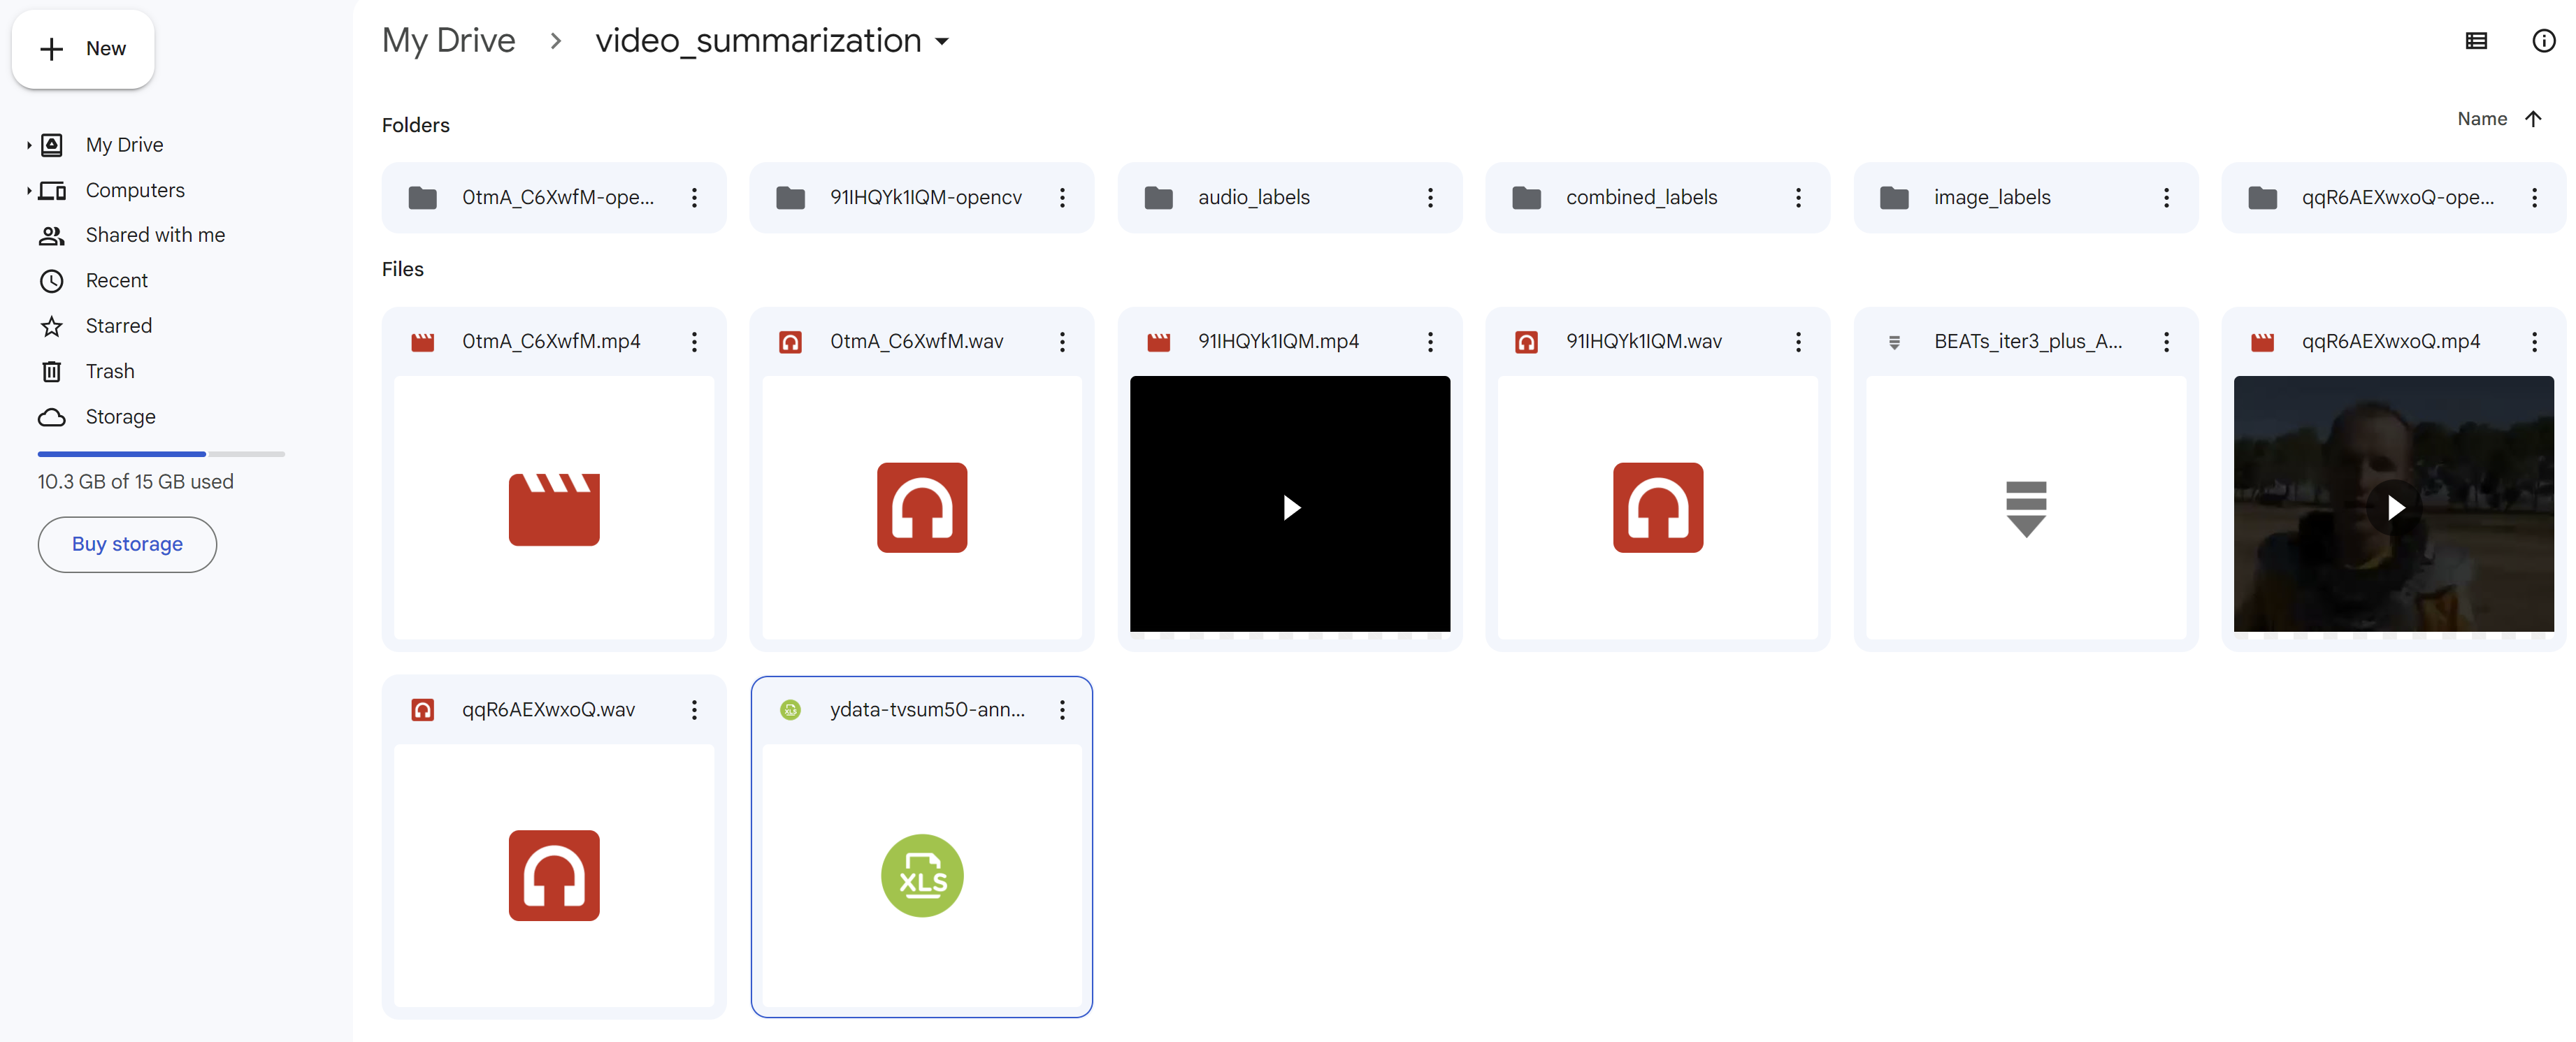

In [ ]:
drive_path = 'video_summarization'
beats_model_choice = 'BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt'
SAVING_FRAMES_PER_SECOND = 6
TOP_AUDIO_LABELS = 5

In [ ]:
import io
import os
import json
# Load in BEATs
!git clone https://github.com/microsoft/unilm.git --quiet
os.chdir('/content/unilm/beats')
from Tokenizers import TokenizersConfig, Tokenizers
from BEATs import BEATs, BEATsConfig
os.chdir('../../')
# Load in ontology
!git clone https://github.com/audioset/ontology.git --quiet
os.chdir('/content/ontology')
f = open('ontology.json')
ontology = json.load(f)
!pip install boto3 --quiet
import boto3
import pandas as pd
import numpy as np
from datetime import timedelta
import sys
import math
import cv2
import torch
import torchaudio
import gc
import tarfile
import tempfile
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
!pip3 install salesforce-lavis --quiet
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/'+drive_path+'/')
sys.path.append('/content/drive/MyDrive/'+drive_path+'/')
anno = pd.read_csv('ydata-tvsum50-anno.tsv', sep='\t', header=None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 KB 27.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend depende

In [ ]:
input_vids = []
for file in os.listdir('./'):
  if file.endswith('.mp4'):
    input_vids.append(file[:-4])
print(input_vids)

['0tmA_C6XwfM', '91IHQYk1IQM', 'qqR6AEXwxoQ']


In [ ]:
# Helper functions
def format_timedelta(td):
    """Utility function to format timedelta objects in a cool way (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return (result + ".00").replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")


def get_saving_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the clip duration by dividing number of frames by the number of frames per second
    clip_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, clip_duration, 1 / saving_fps):
        s.append(i)
    return s

# Main function to extract the frames of a video
def frame_extractor(video_file):
    filename, _ = os.path.splitext(video_file)
    filename += "-opencv"
    # make a folder by the name of the video file
    if not os.path.isdir(filename):
        os.mkdir(filename)
    # read the video file    
    cap = cv2.VideoCapture(video_file)
    # get the FPS of the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    # if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
    saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
    # get the list of duration spots to save
    saving_frames_durations = get_saving_frames_durations(cap, saving_frames_per_second)
    # start the loop
    count = 0
    while True:
        is_read, frame = cap.read()
        if not is_read:
            # break out of the loop if there are no frames to read
            break
        # get the duration by dividing the frame count by the FPS
        frame_duration = count / fps
        try:
            # get the earliest duration to save
            closest_duration = saving_frames_durations[0]
        except IndexError:
            # the list is empty, all duration frames were saved
            break
        if frame_duration >= closest_duration:
            # if closest duration is less than or equals the frame duration, 
            # then save the frame
            frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
            cv2.imwrite(os.path.join(filename, f"frame{frame_duration_formatted}.jpg"), frame) 
            
            # drop the duration spot from the list, since this duration spot is already saved
            try:
                saving_frames_durations.pop(0)
            except IndexError:
                pass
        # increment the frame count
        count += 1

Running the functions to extract videos.



In [ ]:
for vid_name in input_vids:
  if os.path.exists(vid_name+'-opencv/'):
    print(vid_name+ " already has extracted frames")
  else:
    print("Extracting frames from "+vid_name)
    frame_extractor(vid_name+'.mp4')

0tmA_C6XwfM already has extracted frames
91IHQYk1IQM already has extracted frames
qqR6AEXwxoQ already has extracted frames


In [ ]:
def loadImg(imgPath):
  return Image.open(requests.get(imgPath, stream=True).raw).convert('RGB')  
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

## Load pretrained/finetuned BLIP2 captioning model

In [ ]:
# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip_caption", model_type="base_coco", is_eval=True, device=device
)

# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

  0%|          | 0.00/2.50G [00:00<?, ?B/s]

dict_keys(['train', 'eval'])

In [ ]:
def visual_caption_generator(vid_name):
  frames_dir = vid_name + "-opencv"
  fields = ["Title", "Cap1", "Cap2", "Cap3"]
  rows = []
  for rawImg in os.listdir(frames_dir):
    procRaw = Image.open(frames_dir + "/" + rawImg).convert("RGB")
    image = vis_processors["eval"](procRaw).unsqueeze(0).to(device)
    rows.append([rawImg] + model.generate({"image": image}, use_nucleus_sampling=True, num_captions=3))
  sorted(rows, key=lambda x: x[0], reverse=False)
  df = pd.DataFrame(rows, columns=fields, dtype=float)
  df.to_csv('image_labels/'+vid_name+'_visual_labs.csv', index=False)

Generate text description with the model and save it to a list



In [ ]:
for vid_name in input_vids:
  if os.path.exists('image_labels/'+vid_name+'_visual_labs.csv'):
    print(vid_name+ " already has image captions")
  else:
    print('Generating image captions for '+vid_name)
    visual_caption_generator(vid_name)
del model, vis_processors

Generating image captions for 0tmA_C6XwfM
91IHQYk1IQM already has image captions
qqR6AEXwxoQ already has image captions


<ipython-input-9-45ccfbb4a3e6>:6: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  visual_caption_generator(vid_name)


In [ ]:
# Load in BEATs
checkpoint = torch.load(beats_model_choice)
cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])

def get_top_k_labels(audio_input_16khz, k):
  audio_length = audio_input_16khz.shape[1]
  audio_dim = audio_input_16khz.shape[0]
  padding_mask = torch.zeros(audio_dim,audio_length).bool()

  probs = BEATs_model.extract_features(audio_input_16khz, padding_mask=padding_mask)[0]
  for i, (top5_label_prob, top5_label_idx) in enumerate(zip(*probs.topk(k=k))):
      top5_label = [checkpoint['label_dict'][label_idx.item()] for label_idx in top5_label_idx]
      return (top5_label, top5_label_prob)

def plot_2_cols(df, lab1, lab2, kind='line'):
  ax = df.plot(y=lab1, legend=False, kind=kind)
  ax2 = ax.twinx()
  df.plot(y=lab2, ax=ax2, legend=False, color="c", kind=kind)
  ax.figure.legend()
  plt.show()

class Video:
  def __init__(self, vid_name):
    self.name = vid_name
    meta = torchaudio.info(vid_name + '.wav') # load in wav fie for number of frames
    self.num_frames = meta.num_frames # get number of frames total
    self.waveform, self.sample_rate = torchaudio.load(vid_name + '.wav')
    self.slice_waveform() # get cut up waveforms
    cap = cv2.VideoCapture(vid_name+'.mp4')
    self.fps = cap.get(cv2.CAP_PROP_FPS) # get fps through openCV
  def slice_waveform(self):
    scaler = 2*self.sample_rate
    i_range = range(math.ceil(self.num_frames/scaler))
    def bot_slice(i):
      return i*scaler
    def top_slice(i):
      return min((i+1)*scaler, self.num_frames)
    self.waveforms = [self.waveform[:,bot_slice(i):top_slice(i)] for i in i_range]
    self.num_slices = len(self.waveforms)
  def get_k_labels(self, k):
    self.k = k
    self.labels = [get_top_k_labels(wave, k) for wave in self.waveforms]
    label_set = [label[0] for label in self.labels]
    ont_index = lambda label: next((i for i, item in enumerate(ontology) if item['id'] == label), -1)
    a = lambda x: [ontology[ont_index(i)]['name'] for i in x]
    self.english_labels = pd.DataFrame([a(label) for label in label_set])
    return self.english_labels
  def get_scores(self):
    vid_anno = anno.loc[anno[0] == self.name]
    a = lambda x: [int(i) for i in x[1][2].split(',')]
    b = lambda x: pd.DataFrame([a(i) for i in vid_anno.iterrows()])
    # def annotation_string_to_numerics(vid_anno): 
      # return pd.DataFrame([a(annotation) for annotation in vid_anno.iterrows()])
    self.ratings = b(vid_anno)
    scaler = 2*self.fps
    i_range = range(1,math.ceil(self.ratings.shape[1]/scaler))
    def bot_slice(i):
      return int(i*scaler)
    # def top_slice(i):
      # return min((i+1)*scaler, ratings.shape[1])

    abs_scorer = lambda i: sum(abs(self.ratings[bot_slice(i)] - self.ratings[bot_slice(i)+1]))
    abs_score_changes = pd.DataFrame([abs_scorer(i) for i in i_range])

    scorer = lambda i: sum(self.ratings[bot_slice(i)] - self.ratings[bot_slice(i)+1])
    score_changes = pd.DataFrame([scorer(i) for i in i_range])

    changes = pd.concat([abs_score_changes, score_changes], axis=1)
    changes.columns = ['Abs Score','Score']
    self.changes = changes

    a = lambda ind, df: pd.Series(df.iloc[ind])
    b = lambda ind, df: len(a(ind, df)) - sum([(item in a(ind+1, df).unique()) for item in a(ind, df)]) 
    label_changes = lambda df: pd.DataFrame([b(i, df) for i in range(df.shape[0]-1)])
    for i in range(1,self.k+1):
      lab_changes = label_changes(self.english_labels.iloc[:,0:i])
      self.changes[str(i)+'Labels'] = lab_changes

def audio_caption_generator(vid_name):
  a = Video(vid_name)
  audio_labels = a.get_k_labels(TOP_AUDIO_LABELS)
  del a
  audio_labels.to_csv('audio_labels/'+vid_name+'_audio_labs.csv')

In [ ]:
for vid_name in input_vids:
  if os.path.exists('audio_labels/'+vid_name+'_audio_labs.csv'):
    print(vid_name+ " already has audio captions")
  else:
    print('Generating audio captions for '+vid_name)
    audio_caption_generator(vid_name)
    # a.get_scores() is an optional function to see the relationship between the top labels changing and scores changing
del checkpoint, cfg, BEATs_model



0tmA_C6XwfM already has audio captions
91IHQYk1IQM already has audio captions
qqR6AEXwxoQ already has audio captions


In [ ]:
def templater(vid_name):
  combined_labs = []
  aligned_scores = []

  # read the video file    
  cap = cv2.VideoCapture(vid_name+'.mp4')
  # get the FPS of the video
  fps = cap.get(cv2.CAP_PROP_FPS)
  audio_labels = pd.read_csv('audio_labels/'+vid_name+'_audio_labs.csv', index_col=0)
  visual_labels = pd.read_csv('image_labels/'+vid_name+'_visual_labs.csv')
  vid_anno = anno.loc[anno[0] == vid_name]
  a = lambda x: [int(i) for i in x[1][2].split(',')]
  b = lambda x: pd.DataFrame([a(i) for i in vid_anno.iterrows()])
  ratings = b(vid_anno)

  scaler = 2*fps
  i_range = range(0,math.ceil(ratings.shape[1]/scaler))
  bot_slice = lambda i: int(i*scaler)
  scorer = lambda i: ratings[bot_slice(i)].mean()
  avg_scores = pd.Series([scorer(i) for i in i_range])
  for x in visual_labels.iterrows():
    frame_time = str(x[1][0])[5:-7]
    frame_times = [int(x) for x in frame_time.split('-')]
    total_frame_times = frame_times[0]*60**2 + frame_times[1]*60 + frame_times[2]
    audio_ind = min(int(total_frame_times/2), audio_labels.shape[0])
    audio_labs_list = audio_labels.iloc[audio_ind]
    audio_labs = ""
    k = audio_labels.shape[1]
    for i in range(k):
      lab = audio_labs_list[i].lower()
      if(i < k-1):
        audio_labs += lab + ", "
      elif k == 1:
        audio_labs += lab
      else:
        audio_labs += "and " + lab
    
    visual_lab = x[1][1]

    aligned_scores.append(avg_scores[audio_ind])
    combined_labs.append("You hear " + audio_labs + " and see " + visual_lab)
  pd.DataFrame([combined_labs, aligned_scores]).transpose().to_csv('combined_labels/'+vid_name+'_combined_labs.csv')

In [ ]:
for vid_name in input_vids:
  if os.path.exists('combined_labels/'+vid_name+'_combined_labs.csv'):
    print(vid_name+ " already has combined captions")
  elif os.path.exists('audio_labels/'+vid_name+'_audio_labs.csv') and os.path.exists('image_labels/'+vid_name+'_visual_labs.csv'):
    print('Generating combined captions for '+vid_name)
    templater(vid_name)
  else:
    print('Missing either audio or video labels for '+vid_name)


Generating combined captions for 0tmA_C6XwfM
91IHQYk1IQM already has combined captions
qqR6AEXwxoQ already has combined captions
